In [1]:
# Importing neccesary Libraries
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertModel, BertConfig
from torch.optim import AdamW
from torch import nn
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

In [2]:
# Mount Drive for the dataset and to save the model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the IMDB review Dataset
file_path = '/content/drive/MyDrive/Year2_Assignment_2/IMDBDataset.csv'
df = pd.read_csv(file_path)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0}) # Labeling the sentiment to values 1 and 0

In [4]:
# Setting a set random seed throughout
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED) # set seed for pytorch on cpu
torch.cuda.manual_seed_all(SEED) # set seed for GPU using CUDA

In [5]:
# Train-Test Split (80% - 20%)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'].values, df['label'].values, test_size=0.2, random_state=42)

In [6]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # Initializing the BERT tockenizer from the pretained google model

class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # converting the single review text to BERT tokens
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding='max_length', # pad to max length
            return_attention_mask=True,
            return_tensors='pt', # return pytorch tensors
        )
        # Returns a dictionary of input ids, attention masks and labels
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# Creating Dataloaders for batching and shuffling training data
train_dataset = IMDBDataset(train_texts, train_labels, tokenizer)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [8]:
# Defining Model with Frozen BERT
class SentimentClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Unfreezing the last encoder layer and pooler
        for name, param in self.bert.named_parameters():
            if 'encoder.layer.11' in name or 'pooler' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False  # keeps others frozen

        # Dropout layer
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.bert.config.hidden_size, 2) # output size 2 for binary classification
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        return self.classifier(cls_output)

In [9]:
# Training setup and initianization of the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier().to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Lists for storing losses and accuracies
train_losses = []
val_losses = []
test_accuracies = []
train_accuracies = []

# Training Loop
for epoch in range(3):
    model.train()   # Training mode
    total_loss = 0
    # Iterate over the batches
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad() # Clear gradients
        loss.backward()       # Backpropagation
        optimizer.step()      # Update weights

        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [10]:
    # Validation Loss
    model.eval() # sets model to evaluation mode
    total_val_loss = 0
    with torch.no_grad(): # setting no gradient calculation for validation
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Epoch 3 | Train Loss: 0.2329 | Val Loss: 0.2262


In [11]:
    # Calculate accuracy and F1 score
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, dim=1)
            preds.extend(predicted.cpu().numpy()) # gets predicted class index
            true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    test_accuracies.append(accuracy)
    print(f"\n Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")


 Test Accuracy: 0.9062, F1 Score: 0.9086


In [12]:
# Saving the model and tokenizer to google  drive
model_save_path = "/content/drive/MyDrive/Year2_Assignment_2/bert_sentiment_model"
tokenizer.save_pretrained(model_save_path)
torch.save(model.state_dict(), f"{model_save_path}/model.pt")

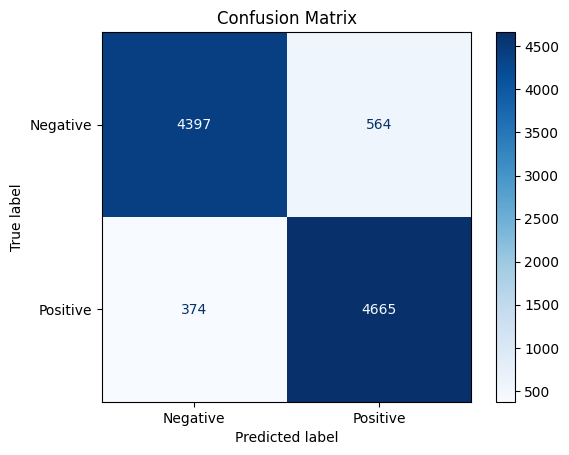

In [13]:
# Plotting confusion matrix
cm = confusion_matrix(true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [33]:
# Predictions
print("\n🔍 Sample predictions:")
for i in range(5):
    print(f"\nReview: {test_texts[i][:200]}...")
    print(f"Actual: {test_labels[i]}, Predicted: {preds[i]}")


🔍 Sample predictions:

Review: I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ev...
Actual: 1, Predicted: 0

Review: Not many television shows appeal to quite as many different kinds of fans like Farscape does...I know youngsters and 30/40+ years old;fans both Male and Female in as many different countries as you ca...
Actual: 1, Predicted: 1

Review: The film quickly gets to a major chase scene with ever increasing destruction. The first really bad thing is the guy hijacking Steven Seagal would have been beaten to pulp by Seagal's driving, but tha...
Actual: 0, Predicted: 0

Review: Jane Austen would definitely approve of this one!<br /><br />Gwyneth Paltrow does an awesome job capturing the attitude of Emma. She is funny without being excessively silly, yet elegant. She puts on ...
Actual: 1, Predicted: 1

Review: Expectations were so

In [16]:
def predict_sentiment(model, tokenizer, sentence, max_len=256):
    model.eval()
    encoding = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probs, dim=1)

    label = 'Positive' if predicted_class.item() == 1 else 'Negative'
    return label, confidence.item()

# Example usage on a new sentence
new_sentence = "This movie was good. But it could be so much better."
pred_label, pred_confidence = predict_sentiment(model, tokenizer, new_sentence)
print(f"\nNew Sentence: {new_sentence}")
print(f"Predicted sentiment: {pred_label} (Confidence: {pred_confidence:.4f})")


New Sentence: This movie was good. But it could be so much better.
Predicted sentiment: Negative (Confidence: 0.5584)


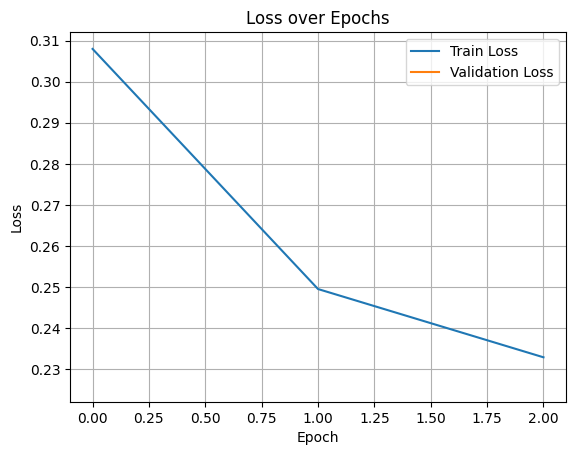

In [17]:
# Plot Loss Curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()